In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/furniture/

/content/drive/MyDrive/furniture


In [ ]:
# %mkdir data

In [ ]:
# !unzip Defaults-Detection2.zip -d data/

Archive:  Defaults-Detection2.zip
   creating: data/neg/
  inflating: data/neg/-vector-id165981238.jpg  
  inflating: data/neg/1000_F_201519164_vNGmG6D4244WQVkcqzBSJA0HMkBFTwyF.jpg  
  inflating: data/neg/17db9286303c9030e93296b704cb8fe8.jpg  
  inflating: data/neg/32inch-Capacitive-Touch-LCD-Monitor-with-LED-Lights.jpg  
  inflating: data/neg/3d-render-of-realistics-coffee-mug-red-for-product-display-picture-id1320066263.jpg  
  inflating: data/neg/511pmCDXWCS._AC_SY450_.jpg  
  inflating: data/neg/61WUIBjK4PL._AC_SX466_.jpg  
  inflating: data/neg/674175dff3-2332999ec02ad513bfda27243e73e200.jpg  
  inflating: data/neg/960.jpg        
  inflating: data/neg/abstract-pastel-yellow-studio-background-for-product-presentation-picture-id1322375999.jpg  
  inflating: data/neg/abstract-white-studio-background-for-product-presentation-empty-room-picture-id1322376077.jpg  
  inflating: data/neg/ajohnson_220425_5165_0002_squ.jpg  
  inflating: data/neg/an-empty-bright-room-with-parquet-flooring-

# Image Processing

In [6]:
import numpy as np 
import cv2
import os
from glob import glob


In [32]:
XTrain = []
YTrain =[]

count = 0
for i in ['defected_wall','mugs-dataset','screens-broken','neg']:
  dirs = os.listdir(f'data/{i}')
  for name in dirs:
    img = cv2.imread(f"data/{i}/{name}")
    img = cv2.resize(img,(100,100))
    img = img/255.0
    XTrain.append(img)
    YTrain.append(count)
  count += 1

In [33]:
np.array(XTrain).shape,np.array(YTrain).shape

((961, 100, 100, 3), (961,))

In [34]:

XTrain = np.array(XTrain)
YTrain = np.array(YTrain)

In [35]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(XTrain, YTrain, test_size=.30,random_state=10)

In [36]:
import pandas as pd
pd.Series(ytrain).value_counts()

3    196
0    171
1    160
2    145
dtype: int64

In [99]:
from tensorflow.keras.applications import ResNet50V2

conv_base = ResNet50V2(weights='imagenet',
include_top=False,
input_shape=(100, 100, 3))

print(conv_base.summary())

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_10[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 52, 52, 64)   0           ['conv1_conv[0][0]']    

In [100]:
print("Total Trainable Layers: {}".format(len(conv_base.layers)))

Total Trainable Layers: 190


In [85]:
for layer in conv_base.layers[-100:]:
  layer.trainable = False

In [101]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dropout, Dense
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(4, activation='softmax'))
print(model.summary())


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 flatten_11 (Flatten)        (None, 32768)             0         
                                                                 
 dense_37 (Dense)            (None, 100)               3276900   
                                                                 
 dense_38 (Dense)            (None, 80)                8080      
                                                                 
 dense_39 (Dense)            (None, 4)                 324       
                                                                 
Total params: 26,850,104
Trainable params: 26,804,664
Non-trainable params: 45,440
_________________________________________________________________
None


In [102]:
model.compile(optimizer = 'adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [103]:
model.fit(xtrain,ytrain,epochs=100,batch_size=100, validation_data = (xtest,ytest))

Epoch 1/100
7/7 [==============================] - 12s 550ms/step - loss: 1.2817 - accuracy: 0.5640 - val_loss: 6.0691 - val_accuracy: 0.3218
Epoch 2/100
7/7 [==============================] - 2s 278ms/step - loss: 0.3650 - accuracy: 0.8750 - val_loss: 14.4309 - val_accuracy: 0.2561
Epoch 3/100
7/7 [==============================] - 2s 280ms/step - loss: 0.1692 - accuracy: 0.9539 - val_loss: 11.6574 - val_accuracy: 0.2388
Epoch 4/100
7/7 [==============================] - 2s 296ms/step - loss: 0.1461 - accuracy: 0.9479 - val_loss: 17.0924 - val_accuracy: 0.2353
Epoch 5/100
7/7 [==============================] - 2s 282ms/step - loss: 0.1137 - accuracy: 0.9598 - val_loss: 25.1761 - val_accuracy: 0.2353
Epoch 6/100
7/7 [==============================] - 2s 282ms/step - loss: 0.0594 - accuracy: 0.9821 - val_loss: 13.4278 - val_accuracy: 0.2837
Epoch 7/100
7/7 [==============================] - 2s 283ms/step - loss: 0.1251 - accuracy: 0.9732 - val_loss: 17.3263 - val_accuracy: 0.2595
Epoch 

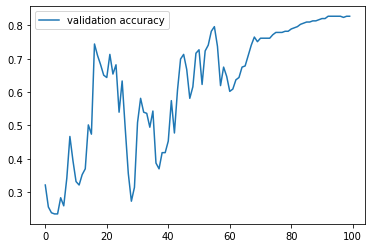

In [105]:
import matplotlib.pyplot as  plt 
plt.plot([i for i in range(len(model.history.history['val_accuracy']))],
         model.history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show();

In [106]:
%ls

data/  Defaults-Detection2.zip  Defaults-Detection.zip  Furniture.h5


In [107]:
model.save("Resnet50V2_82p.h5")

In [110]:
from sklearn.metrics import classification_report
print(classification_report(ytest,np.argmax(model.predict(xtest),axis=1)))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95        84
           1       0.81      0.79      0.80        72
           2       0.77      0.84      0.80        68
           3       0.75      0.66      0.70        65

    accuracy                           0.83       289
   macro avg       0.82      0.82      0.82       289
weighted avg       0.82      0.83      0.82       289



{'Classified_Class': 'Nothing Detected'}
